This notebook examines the diabetes dataset provided by sklearn to test different classification methods.


Data Set Characteristics:

- Number of Instances: 442

- Number of Attributes: First 10 columns are numeric predictive values

- Target: Column 11 is a quantitative measure of disease progression one year after baseline

Attribute Information
- age: age in years

- sex: binary

- bmi: body mass index

- bp: average blood pressure

- s1: tc, total serum cholesterol

- s2: ldl, low-density lipoproteins

- s3: hdl, high-density lipoproteins

- s4: tch, total cholesterol / HDL

- s5: ltg, possibly log of serum triglycerides level

- s6: glu, blood sugar level

# Imports and helper functions

In [12]:
from sklearn.datasets import load_diabetes
import seaborn as sns
from sklearn.model_selection import train_test_split
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category = UserWarning, module = "matplotlib")
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as pl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score, accuracy_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from copy import deepcopy


def distribution(data, transformed = False, cols = None):
    """
    Visualization code for displaying skewed distributions of features
    """
    
    assert cols, "GIVE ME COLUMN NAMES PLEASE"
    # Create figure
    fig = pl.figure(figsize = (5*len(cols),5));

    # Skewed feature plotting
    for i, feature in enumerate(cols):
        ax = fig.add_subplot(1, len(cols), i+1)
        ax.hist(data[feature], bins = 25, color = '#00A0A0')
        ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
        ax.set_xlabel("Value")
        ax.set_ylabel("Num")
        ax.set_ylim((0, 500))
    fig.tight_layout()
    fig.show()


def evaluate(results, accuracy, f1):
    """
    Visualization code to display results of various learners.
    
    inputs:
      - learners: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'
      - accuracy: The score for the naive predictor
      - f1: The score for the naive predictor
    """
  
    # Create figure
    fig, ax = pl.subplots(2, 3, figsize = (11,8))

    # Constants
    bar_width = 0.3
    colors = ['#A00000','#00A0A0','#00A000']
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'acc_train', 'f_train', 'pred_time', 'acc_test', 'f_test']):
            for i in np.arange(3):
                
                # Creative plot code
                ax[j//3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j//3, j%3].set_xticks([0.45, 1.45, 2.45])
                ax[j//3, j%3].set_xticklabels(["1%", "10%", "100%"])
                ax[j//3, j%3].set_xlabel("Training Set Size")
                ax[j//3, j%3].set_xlim((-0.1, 3.0))
    
    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Accuracy Score")
    ax[0, 2].set_ylabel("F-score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Accuracy Score")
    ax[1, 2].set_ylabel("F-score")
    
    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("Accuracy Score on Training Subset")
    ax[0, 2].set_title("F-score on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("Accuracy Score on Testing Set")
    ax[1, 2].set_title("F-score on Testing Set")
    
    # Add horizontal lines for naive predictors
    ax[0, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[0, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    
    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    pl.legend(handles = patches, bbox_to_anchor = (-.80, 2.53), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')
    
    # Aesthetics
    pl.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, x = 0.63, y = 1.05)
    # Tune the subplot layout
    # Refer - https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.subplots_adjust.html for more details on the arguments
    pl.subplots_adjust(left = 0.125, right = 1.2, bottom = 0.1, top = 0.9, wspace = 0.2, hspace = 0.3)    
    pl.tight_layout()
    pl.show()
    

def feature_plot(importances, X_train, y_train):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:5]]
    values = importances[indices][:5]

    # Creat the plot
    fig = pl.figure(figsize = (9,5))
    pl.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    pl.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    pl.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    pl.xticks(np.arange(5), columns)
    pl.xlim((-0.5, 4.5))
    pl.ylabel("Weight", fontsize = 12)
    pl.xlabel("Feature", fontsize = 12)
    
    pl.legend(loc = 'upper center')
    pl.tight_layout()
    pl.show() 

# Load dataset

In [2]:
X, y = load_diabetes(return_X_y=True, as_frame=True)

In [3]:
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


In [7]:
y.head()

0    151.0
1     75.0
2    141.0
3    206.0
4    135.0
Name: target, dtype: float64

<AxesSubplot:xlabel='bmi', ylabel='target'>

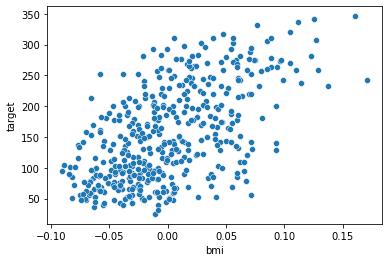

In [6]:
sns.scatterplot(x = X['bmi'], y = y)

## Make sure all data points are normalised

/tmp/ipykernel_112481/314274029.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


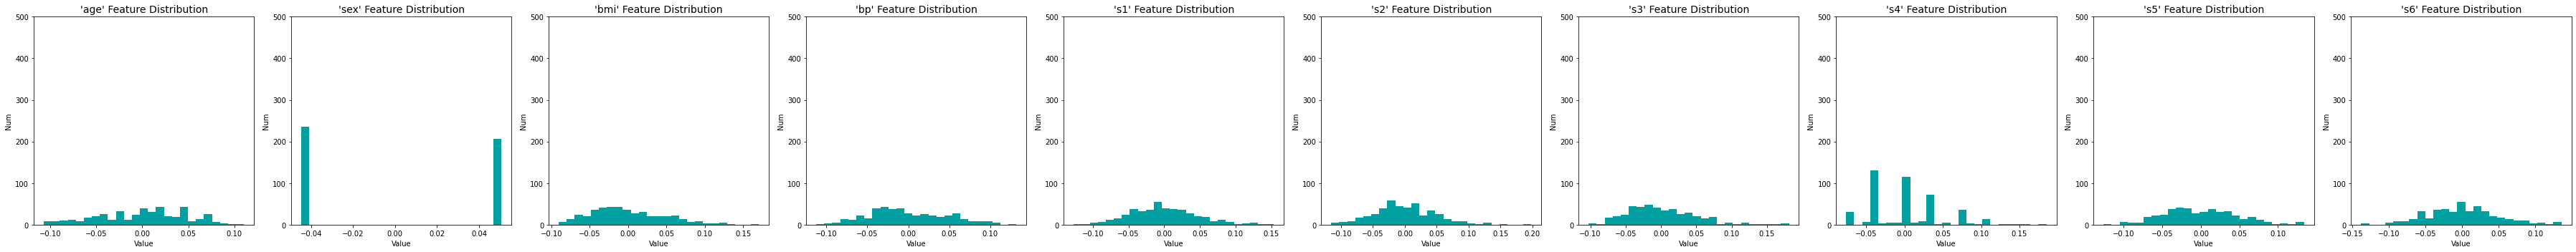

In [8]:
distribution(X, transformed = False, cols = ["age",	"sex",	"bmi",	"bp",	"s1",	"s2",	"s3",	"s4",	"s5",	"s6"])

In [9]:
# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 353 samples.
Testing set has 89 samples.


# Time to make models

Compare regular LinearRegression with Lasso regression, i.e. L1 regularization

In [10]:
model = LinearRegression()
model.fit(X_train, y_train)
prediction = model.predict(X_test)

error = mean_squared_error(y_test, prediction)
print(f"MSE = {error:.2f}")

MSE = 2900.17


In [11]:
model = Lasso(0.1)
model.fit(X_train, y_train)
prediction = model.predict(X_test)

error = mean_squared_error(y_test, prediction)
print(f"MSE = {error:.2f}")

MSE = 2798.19


To find optimal $\alpha$ parameter perform grid search

In [21]:
from sklearn.metrics import r2_score

In [31]:
clf = Lasso()

parameters = {'alpha': np.linspace(0.01,1.5,100)}
scorer = make_scorer(r2_score)
# scorer = make_scorer(f1_score)

grid_obj = GridSearchCV(clf, parameters,scoring=scorer)
grid_fit = grid_obj.fit(X_train, y_train)
best_clf = grid_fit.best_estimator_
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)
print(best_clf)
error = mean_squared_error(y_test, best_predictions)
print(f"MSE = {error:.2f}")

Lasso(alpha=0.08525252525252525)
MSE = 2799.30


# From regression to classification

Make y_train and y_test boolean (cut value 150.0)

In [38]:
y_train_bool =  y_train < 150
y_test_bool = y_test-150 < 0

Compare accuracies of GaussianNB, DecisionTreeClassifier, LogisticRegression, SVC

In [44]:
cl_nb = GaussianNB()
cl_dt = DecisionTreeClassifier()
cl_lr = LogisticRegression()
cl_svc = SVC()

cl_nb.fit(X_train, y_train_bool)
cl_dt.fit(X_train, y_train_bool)
cl_lr.fit(X_train, y_train_bool)
cl_svc.fit(X_train, y_train_bool)
preds_nb = cl_nb.predict(X_test)
preds_dt = cl_dt.predict(X_test)
preds_lr = cl_lr.predict(X_test)
preds_svc = cl_svc.predict(X_test)

acc_nb = accuracy_score(y_test_bool, preds_nb)
acc_dt = accuracy_score(y_test_bool, preds_dt)
acc_lr = accuracy_score(y_test_bool, preds_lr)
acc_svc = accuracy_score(y_test_bool, preds_svc)
print(f"Accuracy (NaiveBayes) = {acc_nb:.2f}")
print(f"Accuracy (DecisionTrees) = {acc_dt:.2f}")
print(f"Accuracy (LogisticRegression) = {acc_lr:.2f}")
print(f"Accuracy (SVC) = {acc_svc:.2f}")

Accuracy (NaiveBayes) = 0.74
Accuracy (DecisionTrees) = 0.57
Accuracy (LogisticRegression) = 0.78
Accuracy (SVC) = 0.76


Grid search on hyperparameters to increase accuracy.

In [65]:
clf = GaussianNB()

parameters = {'var_smoothing': [1e-9,1e-8,1e-10]}
scorer = make_scorer(fbeta_score, beta=0.5)

grid_obj = GridSearchCV(clf, parameters,scoring=scorer)
grid_fit = grid_obj.fit(X_train,y_train_bool)
best_clf = grid_fit.best_estimator_
predictions = (clf.fit(X_train, y_train_bool)).predict(X_test)
best_predictions = best_clf.predict(X_test)
print(f"Old Accuracy (NaiveBayes) = {acc_nb:.2f}")
print(best_clf)
accuracy_score(y_test_bool, best_predictions)

Old Accuracy (NaiveBayes) = 0.75
GaussianNB()


0.7415730337078652

In [66]:
clf = DecisionTreeClassifier()

parameters = {"max_depth": [1, 2, 3] ,"min_samples_split":[0.1,0.5,2,3,4]}
scorer = make_scorer(fbeta_score, beta=0.5)

grid_obj = GridSearchCV(clf, parameters,scoring=scorer)
grid_fit = grid_obj.fit(X_train,y_train_bool)
best_clf = grid_fit.best_estimator_
predictions = (clf.fit(X_train, y_train_bool)).predict(X_test)
best_predictions = best_clf.predict(X_test)
print(f"Old Accuracy (DecisionTrees) = {acc_dt:.2f}")
print(best_clf)

accuracy_score(y_test_bool, best_predictions)

Old Accuracy (DecisionTrees) = 0.60
DecisionTreeClassifier(max_depth=2, min_samples_split=0.5)


0.7415730337078652

In [67]:
clf = LogisticRegression()

parameters = {"C":[0.1,0.5,1,2,3]}
scorer = make_scorer(fbeta_score, beta=0.5)

grid_obj = GridSearchCV(clf, parameters,scoring=scorer)
grid_fit = grid_obj.fit(X_train,y_train_bool)
best_clf = grid_fit.best_estimator_
predictions = (clf.fit(X_train, y_train_bool)).predict(X_test)
best_predictions = best_clf.predict(X_test)
print(f"Old Accuracy (LogisticRegression) = {acc_lr:.2f}")
print(best_clf)
accuracy_score(y_test_bool, best_predictions)

Old Accuracy (LogisticRegression) = 0.78
LogisticRegression(C=2)


0.7640449438202247

In [68]:
clf = SVC()

parameters = {"C":[0.1,0.5,1,2,3]}
scorer = make_scorer(fbeta_score, beta=0.5)

grid_obj = GridSearchCV(clf, parameters,scoring=scorer)
grid_fit = grid_obj.fit(X_train,y_train_bool)
best_clf = grid_fit.best_estimator_
predictions = (clf.fit(X_train, y_train_bool)).predict(X_test)
best_predictions = best_clf.predict(X_test)
print(f"Accuracy (SVC) = {acc_svc:.2f}")
print(best_clf)
accuracy_score(y_test_bool, best_predictions)

Accuracy (SVC) = 0.79
SVC(C=0.5)


0.7303370786516854

# Investigate Imputing in Sklearn

Train a classifier with `X_train_challenge` and `y_train_bool`.
Find the best classifier accuracy score with `X_test` and `y_test_bool`

In [75]:
X_train_challenge = deepcopy(X_train)
X_train_challenge["age_new"] = X_train_challenge.apply(lambda x: np.nan if x.name%5==0 else x["age"], axis=1)
X_train_challenge.drop(columns=["age"], inplace=True)

first_column = X_train_challenge.pop('age_new')
  
X_train_challenge.insert(0, 'age', first_column)
print(X_train_challenge.head())

          age       sex       bmi        bp        s1        s2        s3  \
17   0.070769  0.050680  0.012117  0.056301  0.034206  0.049416 -0.039719   
66  -0.009147  0.050680 -0.018062 -0.033214 -0.020832  0.012152 -0.072854   
137  0.005383 -0.044642  0.049840  0.097616 -0.015328 -0.016345 -0.006584   
245       NaN -0.044642 -0.035307 -0.029771 -0.056607 -0.058620  0.030232   
31  -0.023677 -0.044642 -0.065486 -0.081414 -0.038720 -0.053610  0.059685   

           s4        s5        s6  
17   0.034309  0.027368 -0.001078  
66   0.071210  0.000271  0.019633  
137 -0.002592  0.017037 -0.013504  
245 -0.039493 -0.049868 -0.129483  
31  -0.076395 -0.037128 -0.042499  


In [76]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X_train_challenge)
#SimpleImputer()
#X = [[np.nan, 2], [6, np.nan], [7, 6]]
X_train_challenge = imp.transform(X_train_challenge)

In [ ]:
Accuracy (NaiveBayes) = 0.74
Accuracy (DecisionTrees) = 0.57
Accuracy (LogisticRegression) = 0.78
Accuracy (SVC) = 0.76

In [77]:
cl_nb = GaussianNB()
cl_dt = DecisionTreeClassifier()
cl_lr = LogisticRegression()
cl_svc = SVC()

cl_nb.fit(X_train_challenge, y_train_bool)
cl_dt.fit(X_train_challenge, y_train_bool)
cl_lr.fit(X_train_challenge, y_train_bool)
cl_svc.fit(X_train_challenge, y_train_bool)
preds_nb = cl_nb.predict(X_test)
preds_dt = cl_dt.predict(X_test)
preds_lr = cl_lr.predict(X_test)
preds_svc = cl_svc.predict(X_test)

acc_nb = accuracy_score(y_test_bool, preds_nb)
acc_dt = accuracy_score(y_test_bool, preds_dt)
acc_lr = accuracy_score(y_test_bool, preds_lr)
acc_svc = accuracy_score(y_test_bool, preds_svc)
print(f"Accuracy (NaiveBayes) = {acc_nb:.2f}")
print(f"Accuracy (DecisionTrees) = {acc_dt:.2f}")
print(f"Accuracy (LogisticRegression) = {acc_lr:.2f}")
print(f"Accuracy (SVC) = {acc_svc:.2f}")

Accuracy (NaiveBayes) = 0.75
Accuracy (DecisionTrees) = 0.63
Accuracy (LogisticRegression) = 0.78
Accuracy (SVC) = 0.79


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
